In [32]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, make_scorer, recall_score, brier_score_loss, plot_precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# libraries for cleaning
import re
import nltk
nltk.download("stopwords") # helps us get rid of stop words
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# tensor flow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/UBDC_2021/Final/trad_ml.csv")
df = df.iloc[:,1:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
df.head()

,favorite_count,retweet_count,user_favourites_count,user_followers_count,user_friends_count,user_statuses_count,user_listed_count,user_active,label,hashtags_1,user_verified_True,place_1
0,0,0,0,104,0,62227,1,440.0,0,0,0,0
1,89,40,18518,49905205,820,435062,209461,4808.0,0,0,1,0
2,2,0,152,1415768,218,118195,1144,3734.0,0,0,0,0
3,0,0,1,984,28,14869,23,3599.0,0,0,0,0
4,0,0,2462,46,107,2361,0,83.0,0,0,0,0


Good explanation of what these columns mean: https://www.kaggle.com/c/covid19-retweet-prediction-challenge-2020/data 

In [35]:
print(df.info())
# created_at, favorite_count, lang, possibly_sensitive, retweet_count, user_created_at,user_favorites_count, user_followers_count, user_friends_count, user_statuses_count, user_verified, label

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221461 entries, 0 to 221460
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   favorite_count         221461 non-null  int64  
 1   retweet_count          221461 non-null  int64  
 2   user_favourites_count  221461 non-null  int64  
 3   user_followers_count   221461 non-null  int64  
 4   user_friends_count     221461 non-null  int64  
 5   user_statuses_count    221461 non-null  int64  
 6   user_listed_count      221461 non-null  int64  
 7   user_active            221461 non-null  float64
 8   label                  221461 non-null  int64  
 9   hashtags_1             221461 non-null  int64  
 10  user_verified_True     221461 non-null  int64  
 11  place_1                221461 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 20.3 MB
None


In [36]:
# split into testing vs training
X = df.drop("label", axis = 1)
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

In [37]:
# standardize
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)


y_test_pred = model.predict(X_test)
y_test_pred_prob = model.predict_proba(X_test)[:,1]

In [39]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     52750
           1       0.05      0.01      0.02      2616

    accuracy                           0.94     55366
   macro avg       0.50      0.50      0.50     55366
weighted avg       0.91      0.94      0.93     55366



In [40]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
auc(fpr, tpr)

0.5006738916184762

# Logistic Regression

In [41]:
real = y_train.loc[y_train==0].shape[0]
fake = y_train.loc[y_train==1].shape[0]
total = real + fake
weight_0 = (1/real)*(total/2.0)
weight_1 = (1/fake)*(total/2.0)
class_weight = {0:weight_0, 1:weight_1}
print(f"Weight 0 clas is {weight_0}")
print(f"Weight 1 class is {weight_1}")

model = LogisticRegression(random_state=0,penalty="none", class_weight=class_weight)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_test_pred_prob = model.predict_proba(X_test)[:,1]

Weight 0 clas is 0.525165047806951
Weight 1 class is 10.434413871089331


In [42]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.50      0.66     52750
           1       0.06      0.63      0.11      2616

    accuracy                           0.51     55366
   macro avg       0.51      0.57      0.38     55366
weighted avg       0.92      0.51      0.64     55366



In [43]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
auc(fpr, tpr)

0.5653798281084685

[[26578 26172]
 [  976  1640]]


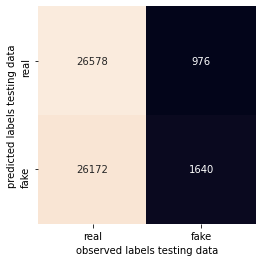

In [44]:
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
sns.heatmap(cm.T, square = True, annot=True, fmt = "d", cbar = False, 
            xticklabels = ["real","fake"], yticklabels = ["real","fake"])
plt.xlabel("observed labels testing data")
plt.ylabel("predicted labels testing data")
plt.savefig("/content/drive/MyDrive/UBDC_2021/Final/confusionmatrixtradml.pdf",bbox_inches = "tight")

# Random Forest


In [45]:
# split into testing vs training
X = df.drop("label", axis = 1)
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

In [46]:
# final rf model 
model = RandomForestClassifier(n_estimators = 60 , verbose = 1,random_state=0, class_weight=class_weight)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   20.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.8s finished


In [47]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     52750
           1       0.85      0.18      0.29      2616

    accuracy                           0.96     55366
   macro avg       0.90      0.59      0.63     55366
weighted avg       0.96      0.96      0.95     55366



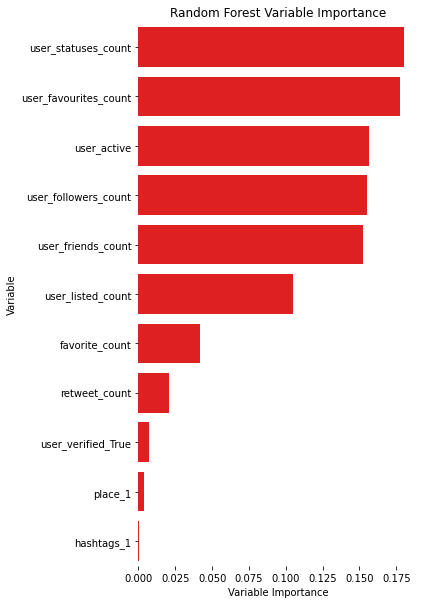

In [48]:
# find variable importance
importance_list = model.feature_importances_
indices = np.argsort(importance_list)[::-1]

f, ax = plt.subplots(figsize = (5,10))
plt.title("Random Forest Variable Importance")
sns.barplot(y=[X_train.columns[i] for i in indices], 
            x = importance_list[indices], 
            label = "total", color = "r")
ax.set(ylabel = "Variable", xlabel = "Variable Importance")
sns.despine(left = True, bottom = True)
plt.savefig("/content/drive/MyDrive/UBDC_2021/Final/tradml_variableimportance.pdf", bbox_inches = "tight")

In [50]:
# for tobi 
corpus = [
'hello this is a test',
'how are you doing?',
'third line - whats up?',
'hihihi my name is tobi',
]
cv = CountVectorizer()
X = cv.fit_transform(corpus)
print(cv.get_feature_names())



['are', 'doing', 'hello', 'hihihi', 'how', 'is', 'line', 'my', 'name', 'test', 'third', 'this', 'tobi', 'up', 'whats', 'you']


In [61]:
# for tobi 
print(X.toarray())
arr = X.toarray()
print(arr)

[[0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0]
 [1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0]
 [0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0]]
[[0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0]
 [1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0]
 [0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0]]
